#  Summer Research \# 3
## Finite Difference Time Domain (FDTD) for Maxwell's Equations

#### Executive Summary
** Insert Executive Summary Here **

### One and Three Dimension Spatial Example


In [101]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as spla
import scipy.sparse as sps

In [2]:
np.random.seed(12345)

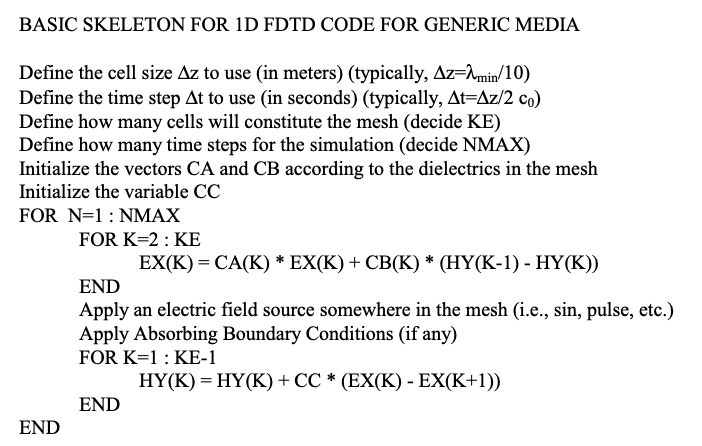

From Utah

In [3]:
def tridiag(a,b,c,n,*, is_sparse: bool = False):
    # Make a tridiagonal matrix, which is common in FDM
    
    if is_sparse == False:
        # Create an n x n tridiagonal matrix with subdiagonal a, diagonal b, and superdiagonal c
        A = np.diag(a * np.ones(n-1), -1) + np.diag(b * np.ones(n)) + np.diag(c * np.ones(n-1), 1)
    else:
        # An Attempt to make a sparse matrix structure. 
        ## Need to test
        ex = np.ones(n)
        data = np.array([a * ex, b * ex, c * ex])
        offsets = np.array([-1, 0, 1])
        A = dia_array((data, offsets), shape=(n, n))
        
        
    return A

In [24]:
# A one dimensional FDTD Example - very naive programming

imp0 = 377.0
n = 200
maxTime = 250


ez = np.zeros(n)
hy = np.zeros(n)
ez50 = np.zeros(maxTime)

A1 = (1/imp0) * tridiag(0,-1,1,n)
A1[-1,:] = 0
A2 = imp0 * tridiag(-1,1,0,n)
A2[0,:] = 0


for qTime in range(maxTime):
    #for mm in range(n-1):
    #    hy[mm] = hy[mm] + (ez[mm+1] - ez[mm]) / imp0

    #for mm in range(1,n):
    #    ez[mm] = ez[mm] + (hy[mm] - hy[mm-1]) * imp0
    hy += A1 @ ez
    ez += A2 @ hy
    ez[50] += np.exp((-(qTime - 30.) ** 2)/ 100.)
    ez50[qTime] = ez[49]
    #print('Electric field:', ez[49], '\n')
        



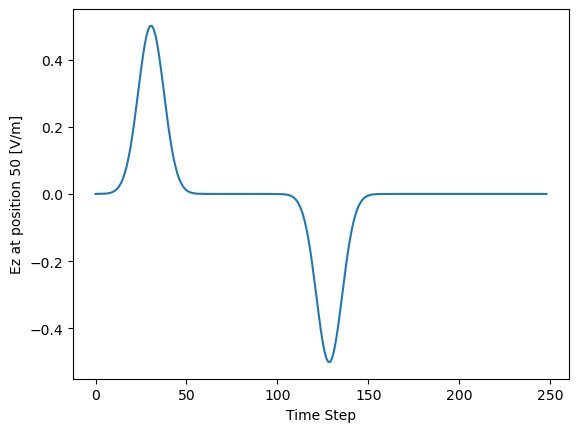

In [25]:
plt.plot(range(qTime), ez50[:-1])
plt.xlabel('Time Step')
plt.ylabel('Ez at position 50 [V/m]')
plt.show()

In [ ]:
# Naive Cartesian First
Ex = np.zeros([nx,ny,nz])
Ey = np.zeros([nx,ny,nz])
Ez = np.zeros([nx,ny,nz])

Hx = np.zeros([nx,ny-1,nz-1])
Hy = np.zeros([nx-1,ny,nz-1])
Hz = np.zeros([nx-1,ny-1,nz])


for n in range(niter):
    # Update Magnetic Field at time step n + 1/2
    Hx = Hx - dt/(mu * dz) * (Ey[:,:, 1:] - Ey[:,:,:-1]) - dt/(mu + dy) * (Ez[:,1:,:] - Ez[:,:-1,:]) 
    Hy = Hy - dt/(mu * dx) * (Ez[1:, :,:] - Ez[:-1,:,:]) - dt/(mu * dz) * (Ex[:,:,1:] - Ex[:,:,:-1])
    Hz = Hz - dt/(mu * dy) * (Ex[:, 1:,:] - Ex[:,:-1,:]) - dt/(mu * dx) * (Ey[1:,:,:] - Ey[:-1,:,:])
    
    
    # Update electric field at time step n + 1
    Ex[1:-1, 1:-1,1:-1] += dt/(ep * dy) * (Hz[1:-1, 1:, 1:-1] - Hz[1:-1, :-1, 1:-1]) - dt/(ep * dz) * (Hy[1:-1, 1:-1,1:] - Hy[1:-1,1:-1,:-1])
    Ey[1:-1, 1:-1,1:-1] += dt/(ep * dz) * (Hx[1:-1, 1:-1,1: ] - Hx[1:-1, 1:-1, :-1]) - dt/(ep * dx) * (Hz[1:, 1:-1,1:-1] - Hz[:-1,1:-1,1:-1])
    Ez[1:-1, 1:-1,1:-1] += dt/(ep * dx) * (Hy[1:, 1:-1, 1:-1] - Hy[:-1, 1:-1, 1:-1]) - dt/(ep * dy) * (Hx[1:-1,1: ,1:-1] - Hx[1:-1,:-1,1:-1])
    
    # Apply Boundary Conditions
    # Homogenous Dirichlet
    # 

### Cylindrical FDTD

Since we are still trying to solve these coupled equation:
\begin{align}
\epsilon\frac{\partial \mathbf{E}}{\partial t} &= \nabla \times \mathbf{H}\\
-\mu\frac{\partial \mathbf{H}}{\partial t} &= \nabla \times \mathbf{E},
\end{align}

so we need to perform the curl in cylindrical coordinates leading to:
\begin{align}
\epsilon\frac{\partial E_r}{\partial t} &= \frac{1}{r}\left(\frac{\partial H_z}{\partial \theta} - \frac{\partial H_\theta}{\partial z}\right)\\
\epsilon\frac{\partial E_\theta}{\partial t} &= \left(\frac{\partial H_r}{\partial z} - \frac{\partial H_z}{\partial r} \right)\\
\epsilon\frac{\partial E_z}{\partial t} &= \frac{1}{r}\left(\frac{\partial (rH_\theta)}{\partial r} - \frac{\partial H_r}{\partial \theta} \\\right)\\
-\mu\frac{\partial H_r}{\partial t} &= \frac{1}{r}\left(\frac{\partial E_z}{\partial \theta} - \frac{\partial E_\theta}{\partial z}\right)\\
-\mu\frac{\partial H_\theta}{\partial t} &= \left(\frac{\partial E_r}{\partial z} - \frac{\partial E_z}{\partial r} \right)\\
-\mu\frac{\partial H_z}{\partial t} &= \frac{1}{r}\left(\frac{\partial (rE_\theta)}{\partial r} - \frac{\partial E_r}{\partial \theta} \\\right)
\end{align}

To discretize this we use the familiar FTCS (forward time, centered space) scheme, which is $\mathcal{O}\left(\Delta t, \left(\Delta x_i\right)^2\right) $ stable, to get the following update scheme.
\begin{align}
E_r\Big\rvert_{i,j,k}^{n+1} &= E_r\Big\rvert_{i,j,k}^n + \frac{\Delta t}{\epsilon} \frac{1}{\left(i+1/2\right) \Delta r} \left(\frac{H_z\Big\rvert_{i,j+1/2,k}^{n+1/2} - H_z\Big\rvert_{i,j-1/2,k}^{n+1/2}}{\Delta \theta} - \frac{H_\theta\Big\rvert_{i,j,k+1/2}^{n+1/2} - H_\theta\Big\rvert_{i,j,k-1/2}^{n+1/2} }{\Delta z}\right)\\
E_\theta\Big\rvert_{i,j,k}^{n+1} &= E_\theta\Big\rvert_{i,j,k}^n + \frac{\Delta t}{\epsilon}\left(\frac{H_r\Big\rvert_{i,j,k+1/2}^{n+1/2} - H_r\Big\rvert_{i,j,k-1/2}^{n+1/2} }{\Delta z} - \frac{H_z\Big\rvert_{i+1/2,j,k}^{n+1/2} - H_z\Big\rvert_{i-1/2,j,k}^{n+1/2}}{\Delta r}\right)\\
E_z\Big\rvert_{i,j,k}^{n+1} &= E_z\Big\rvert_{i,j,k}^n + \frac{\Delta t}{\epsilon} \frac{1}{\left(i+1/2\right) \Delta r} \left(\frac{(i+1/2)H_\theta\Big\rvert_{i+1/2,j,k}^{n+1/2} - (i-1/2)H_\theta\Big\rvert_{i-1/2,j,k}^{n+1/2}}{1} - \frac{H_r\Big\rvert_{i,j+1/2,k}^{n+1/2} - H_r\Big\rvert_{i,j-1/2,k}^{n+1/2} }{\Delta \theta}\right)\\
H_r\Big\rvert_{i,j,k}^{n+1} &= H_r\Big\rvert_{i,j,k}^n - \frac{\Delta t}{\mu} \frac{1}{\left(i+1/2\right) \Delta r} \left( \frac{E_z\Big\rvert_{i,j+1/2,k}^{n+1/2} - E_z\Big\rvert_{i,j-1/2,k}^{n+1/2}}{\Delta \theta} - \frac{E_\theta\Big\rvert_{i,j,k+1/2}^{n+1/2} - E_\theta\Big\rvert_{i,j,k-1/2}^{n+1/2} }{\Delta z}\right)\\
H_\theta\Big\rvert_{i,j,k}^{n+1} &= H_\theta\Big\rvert_{i,j,k}^n - \frac{\Delta t}{\mu}\left(\frac{E_r\Big\rvert_{i,j,k+1/2}^{n+1/2} - E_r\Big\rvert_{i,j,k-1/2}^{n+1/2} }{\Delta z} - \frac{E_z\Big\rvert_{i+1/2,j,k}^{n+1/2} - E_z\Big\rvert_{i-1/2,j,k}^{n+1/2}}{\Delta r}\right)\\
H_z\Big\rvert_{i,j,k}^{n+1} &= H_z\Big\rvert_{i,j,k}^n - \frac{\Delta t}{\mu} \frac{1}{\left(i+1/2\right) \Delta r} \left(\frac{(i+1/2)E_\theta\Big\rvert_{i+1/2,j,k}^{n+1/2} - (i-1/2)E_\theta\Big\rvert_{i-1/2,j,k}^{n+1/2}}{1} - \frac{E_r\Big\rvert_{i,j+1/2,k}^{n+1/2} - E_r\Big\rvert_{i,j-1/2,k}^{n+1/2} }{\Delta \theta}\right)
\end{align}

Using the CFL condition and to avoid numerical dispersion, we need
\begin{align}
\Delta t &= \frac{\alpha}{c}\left(\left(\frac{1}{\Delta r}\right)^2 + \left(\frac{2}{\Delta r \Delta\theta}\right)^2 + \left(\frac{1}{2\Delta z}\right)^2\right)^{-1/2}\\
\Delta r &\leq\frac{\lambda_{\text{min}}}{n},
\end{align}
where $\alpha\in[0,1]$ is a dimensionless constant, $\lambda_{\text{min}}$ is the minimum wavelength that propagates in the grid and $n$ is in the range of 15 to 20.

One thing I think as well is that unlike the advection equation, we are not taking the derivative of all the variables at the same time, but only some of the derivatives at the same time. For example, in the first equation, we are taking the $\theta$ derivative (first term) and the $z$ derivative (second term) but ignoring the $r$ derivative, by assuming its constant. This causes me to believe I need to construct a $\mathbf{L}_r, \mathbf{L}_\theta, \mathbf{L}_z$ matrix differential operator, separately and add at most two of them together. I propose how to do this is by $\mathbf{L}_\ast \otimes \mathbf{I}$. 

\begin{align}
\mathbf{L}_\theta :=\mathbf{I}_z \otimes \mathbf{I}_r \otimes\mathbf{\tilde{L}}_\theta &= \begin{pmatrix}1&&&\\&1&&\\&&\ddots&\\&&&1\end{pmatrix}\otimes\begin{pmatrix}1&&&\\&1&&\\&&\ddots&\\&&&1\end{pmatrix}\otimes\frac{1}{\Delta \theta}\begin{pmatrix}
0 & 1 & 0 & \cdots & -1\\
-1 & 0 & 1 & \cdots & 0\\
\vdots & \ddots & \ddots & \ddots & \vdots\\
1 & 0 &\cdots & -1 & 0
\end{pmatrix}\\
\mathbf{L}_r := \mathbf{I}_z \otimes \mathbf{\tilde{L}}_r \otimes \mathbf{I}_\theta &= \begin{pmatrix}1&&&\\&1&&\\&&\ddots&\\&&&1\end{pmatrix}\otimes\frac{1}{\Delta r}\begin{pmatrix}
-1 & 1 & 0 & \cdots & \\
-0.5 & 0 & 0.5 & \cdots & 0\\
\vdots & \ddots & \ddots & \ddots & \vdots\\
0 & 0 &\cdots & -1 & 1
\end{pmatrix}\otimes\begin{pmatrix}1&&&\\&1&&\\&&\ddots&\\&&&1\end{pmatrix}\\
\mathbf{L}_z := \mathbf{\tilde{L}}_z \otimes \mathbf{I}_r \otimes \mathbf{I}_\theta &= \frac{1}{\Delta z}\begin{pmatrix}
0 & 1 & 0 & \cdots & -1\\
-1 & 0 & 1 & \cdots & 0\\
\vdots & \ddots & \ddots & \ddots & \vdots\\
1 & 0 &\cdots & -1 & 0
\end{pmatrix}\otimes\begin{pmatrix}1&&&\\&1&&\\&&\ddots&\\&&&1\end{pmatrix}\otimes \begin{pmatrix}1&&&\\&1&&\\&&\ddots&\\&&&1\end{pmatrix}
\end{align}

Constructing the $\mathbf{R}$ matrix which is the culmination of the $\frac{1}{i+1/2}$ for each node. N.B., we do not include the $\Delta r$ in this term because for non-uniform grids, $\Delta r$ is non constant, so we can incorporate it separately. We do this by first accessing ```ridx``` which are the values of the radial distances indices in the disks. Let's say we have ```ridx = np.array([1,2,3])``` so we only have points at radial distance 1 unit, 2 units, and 3 units from the origin. There are ```nw = 4``` angular points per level in a disk and ```nz=2``` disks in the $z$-direction. Since the nodes are oriented $(\theta, r,z)$ in the code, we will construct this $\mathbf{R}$ matrix using Kronecker products. (This might seem nonsensical, but the idea is making the boundary conditions easier as we can apply them to a block not elementwise every ```nr``` elements.)

\begin{align}
\mathbf{\tilde{R}} &= \begin{pmatrix}
\frac{1}{1.5}&&\\ &\frac{1}{2.5}&\\ &&\frac{1}{3.5}
\end{pmatrix}\\
\mathbf{I}_{nw} &= \begin{pmatrix}
1&&&\\ &1&&\\ &&1&\\ &&&1
\end{pmatrix}\\
\mathbf{I}_{nz} &= \begin{pmatrix}
1&\\ &1
\end{pmatrix}\\
\mathbf{R} &= \mathbf{I}_{nz} \otimes \left(\mathbf{\tilde{R}} \otimes \mathbf{I}_{nw}\right)
\end{align}

In [174]:
class fd3dGridC:
    """
    a finite-difference grid in cylindrical coordinates
    """

    def __init__(self, nr, nw, nz = 1, ng = 1, rmax=1.0, zmax = 1.0, grid = 'uniform'):
        """
        create a 3D grid with (nr+1) points in the radial direction, (nw + 1) points in the angular direction, and (nz+1) points
        in the axial direction. Additionally calculates dr, dw, dz and the points where the solution is computed.
        """

        self.rmin = 0.0
        self.rmax = rmax

        self.zmin = 0.0
        self.zmax = zmax
        
        self.ng = ng
        self.nr = nr
        self.nw = nw
        self.nz = nz

        self.ilo = ng
        self.ihi = ng+nr-1

        # physical coords
        if grid == 'uniform':
            self.rpts = np.linspace(rmin, rmax, num = nr + 1)
            self.dr = rmax / nr
        elif grid == 'cheb':
            r = rmax * np.polynomial.chebyshev.chebpts1(2*nr)
            self.rpts = np.append(r[nr:],rmax)
            self.dr = self.rpts[1:] - self.rpts[:-1]
        else:
            Exception('radial grid type not supported') 
            
        
        self.dw = 2* np.pi / nw
        self.wpts = np.linspace(0, 2*np.pi, num = nw +1)

        self.dz = zmax / nz
        self.zpnts = np.linspace(0, zmax, num = nz + 1)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]

        # storage for the solution
        # self.sol = np.zeros(nx + 1, dtype=np.float64)
        
        
    #def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
    #    return np.zeros((self.nx+2*self.ng), dtype=np.float64)

In [153]:
# Sparse Working Code - Proof of Concept

# Initialize the solution
# nnds = (nr-1) * nw * nz # Number of nodes (nr-1) ignores outer shell for boundary
Er = np.zeros((nr-2)*nw*nz)
Ew = np.zeros((nr-1)*(nw-1)*nz)
Ez = np.zeros((nr-1)*nw*(nz-1))

Hr = np.zeros((nr-1)*(nw-1)*(nz-1))
Hw = np.zeros(nr-2)*nw*(nz-1))
Hz = np.zeros(nr-2)*(nw-1)*nz)

Ir = sps.identity(nr)
Iw = sps.identity(nw)
Iz = sps.identity(nz)

# Prep to construct ciculant matrix
firstcolw = np.zeros(nw)
firstcolw[1], firstcolw[-1] = 1, -1

firstcolz = np.zeros(nz)
firstcolz[1], firstcolz[-1] = 1, -1

# Prep to construct DIA matrix
er = np.ones(nr)
data = np.array([er, -1 * er])
offsets = np.array([-1, 1])

# Construct Difference Operators wrt r, theta, z
Lr = sps.dia_array((data, offsets), shape=(nr, nr))
Lw = spla.circulant(firstcolw)
Lz = spla.circulant(firstcolz)

# Put operators with the right nodes with Kron Prods
## Might not need to form these explicitly. Consider (AxB)vec(X) = vec(B^TXA)
Lr = (1./ dr) * sps.kron(Iz,sps.kron(Lr,Iw))
Lw = (1./ dw) * sps.kron(Iz,sps.kron(Ir,Lw))
Lz = (1./ dz) * sps.kron(Lz,sps.kron(Ir,Iw))


# Construct the R Matrix 1/(i+0.5) forall i
ridx = np.arange(nr-1)
r = 1./(ridx + 0.5)
R = sps.dia_array((r,0), shape = (nr,nr))
R = sps.kron(Iz,sps.kron(R,Iw))

# Construct i+1 matrix and i-1 matrix
rp1 = ridx + 0.5
rm1 = ridx - 0.5
data = np.array([rm1* ex,rp1 * ex])
Ip1 = sps.dia_array((data,offsets), shape = (nr,nr))
Ip1 = sps.kron(Iz,sps.kron(Ip1,Iw))


# Will impliment later, will allow for F-C Node Placement
dR = sps.dia_array((1./dr,0), shape = (nr,nr))

# Gaussian pulse
t0=20
spread=8
midpoint = 0

# Inner Loop
for t in range(niter):
    # Update Magnetic Field at time step n + 1/2 
    mv1, mv2 = Lw @ Ez, Lz @ Ew
    mv1[-1], mv2[-1] = 0, 0
    Hr -= (dt / mu) * dR * (R *(mv1 - mv2))

    mv1, mv2 = Lr @ Ez, Lz @ Er
    mv1[-1], mv2[-1] = 0, 0
    Hw -= (dt / mu) *(mv1 - mv2)

    mv1, mv2 = Ip1 @ Ew, Lw @ Er
    mv1[-1], mv2[-1] = 0, 0
    Hz -= (dt / mu) * dR * (R *(mv1 - mv2))

    # Update electric field at time step n + 1
    mv1, mv2 = Lw @ Hz, Lz @ Hw
    mv1[0], mv2[0] = 0, 0
    Er += (dt / ep) * dR * (R *(mv1 - mv2))

    mv1, mv2 = Lr @ Hz, Lz @ Hr
    mv1[0], mv2[0] = 0, 0
    Ew += (dt / ep) *(mv1 - mv2)

    mv1, mv2 = Ip1 @ Ew, Lw @ Er
    mv1[0], mv2[0] = 0, 0
    Ez -= (dt / mu) * dR * (R *(mv1 - mv2))

    # Add Source Term
    Er(midpoint)= np.kron(Iz,np.kron(np.exp(-0.5*((t-t0)/spread)^2), Iw))

    # Enforce Boundary conditions

NameError: name 'Lr' is not defined

### Spherical FDTD

N.B. Much to my chagrin, we are going to use the physics notation for this, where $r$ is the radial length, $\theta$ is the polar angle, or angle from the North pole, and $\phi$ is the azmuthal angle, or angle in the $x-y$ plane.

This means that the equations for the Maxwell's Equations are:
\begin{align}
\epsilon\frac{\partial E_r}{\partial t} &= \frac{1}{r\sin\theta}\left(\frac{\partial \left(\sin\theta H_\phi\right)}{\partial \theta} - \frac{\partial H_\theta}{\partial \phi}\right)\\
\epsilon\frac{\partial E_\theta}{\partial t} &= \frac{1}{r}\left(\frac{1}{\sin\theta}\frac{\partial H_r}{\partial \phi} - \frac{\partial \left(rH_\phi\right)}{\partial r}\right)\\
\epsilon\frac{\partial E_\phi}{\partial t} &= \frac{1}{r}\left(\frac{\partial \left(rH_\theta\right)}{\partial r} - \frac{\partial H_r}{\partial\theta}\right)\\
-\mu\frac{\partial H_r}{\partial t} &= \frac{1}{r\sin\theta}\left(\frac{\partial \left(\sin\theta E_\phi\right)}{\partial \theta} - \frac{\partial E_\theta}{\partial \phi}\right)\\
-\mu\frac{\partial H_\theta}{\partial t} &= \frac{1}{r}\left(\frac{1}{\sin\theta}\frac{\partial E_r}{\partial \phi} - \frac{\partial \left(rE_\phi\right)}{\partial r}\right)\\
-\mu\frac{\partial H_\phi}{\partial t} &= \frac{1}{r}\left(\frac{\partial \left(rE_\theta\right)}{\partial r} - \frac{\partial E_r}{\partial\theta}\right)
\end{align}

When we discretize it, we see the following:
\begin{align}
    E_r\Big\rvert_{i,j,k}^{n+1} &= E_r\Big\rvert_{i,j,k}^n + \frac{\Delta t}{\epsilon}\frac{\Delta \theta/2}{i\Delta r \sin (j\Delta\theta) \sin(\Delta\theta/2)}\left(\frac{\sin((j+1/2)\Delta\theta)H_\phi\Big\rvert_{i,j+1/2,k}^{n+1/2} - \sin((j-1/2)\Delta\theta)H_\phi\Big\rvert_{i,j-1/2,k}^{n+1/2}}{\Delta \theta} - \frac{H_\theta\Big\rvert_{i,j,k+1/2}^{n+1/2} - H_\theta\Big\rvert_{i,j,k-1/2}^{n+1/2}}{\Delta\phi}\right)\\
    E_\theta\Big\rvert_{i,j,k}^{n+1} &= E_\theta\Big\rvert_{i,j,k}^{n} + \frac{\Delta t}{\epsilon}\frac{1}{i\Delta r}\left(\frac{H_r\Big\rvert_{i,j,k+1/2}^{n+1/2} - H_r\Big\rvert_{i,j,k-1/2}^{n+1/2}}{\sin(j\Delta \theta)\Delta\phi} - \frac{(i+1/2)H_\phi\Big\rvert_{i+1/2,j,k}^{n+1/2} - (i-1/2)H_\phi\Big\rvert_{i-1/2,j,k}^{n+1/2}}{\Delta\phi}\right)\\
    E_\phi\Big\rvert_{i,j,k}^{n+1} &= E_\phi\Big\rvert_{i,j,k}^{n} + \frac{\Delta t}{\epsilon}\frac{1}{i\Delta r}\left(\frac{(i+1/2)H_\theta\Big\rvert_{i+1/2,j,k}^{n+1/2} - (i-1/2)H_\theta\Big\rvert_{i-1/2,j,k}^{n+1/2}}{1} - \frac{H_r\Big\rvert_{i,j+1/2,k}^{n+1/2} - H_r\Big\rvert_{i,j-1/2,k}^{n+1/2}}{\Delta\theta}\right)\\
      H_r\Big\rvert_{i,j,k}^{n+1} &= H_r\Big\rvert_{i,j,k}^n - \frac{\Delta t}{\mu}\frac{\Delta \theta/2}{i\Delta r \sin (j\Delta\theta) \sin(\Delta\theta/2)}\left(\frac{\sin((j+1/2)\Delta\theta)E_\phi\Big\rvert_{i,j+1/2,k}^{n+1/2} - \sin((j-1/2)\Delta\theta)E_\phi\Big\rvert_{i,j-1/2,k}^{n+1/2}}{\Delta \theta} - \frac{E_\theta\Big\rvert_{i,j,k+1/2}^{n+1/2} - E_\theta\Big\rvert_{i,j,k-1/2}^{n+1/2}}{\Delta\phi}\right)\\
    H_\theta\Big\rvert_{i,j,k}^{n+1} &= H_\theta\Big\rvert_{i,j,k}^{n} - \frac{\Delta t}{\mu}\frac{1}{i\Delta r}\left(\frac{E_r\Big\rvert_{i,j,k+1/2}^{n+1/2} - E_r\Big\rvert_{i,j,k-1/2}^{n+1/2}}{\sin(j\Delta \theta)\Delta\phi} - \frac{(i+1/2)E_\phi\Big\rvert_{i+1/2,j,k}^{n+1/2} - (i-1/2)E_\phi\Big\rvert_{i-1/2,j,k}^{n+1/2}}{\Delta\phi}\right)\\
    H_\phi\Big\rvert_{i,j,k}^{n+1} &= H_\phi\Big\rvert_{i,j,k}^{n} - \frac{\Delta t}{\mu}\frac{1}{i\Delta r}\left(\frac{(i+1/2)E_\theta\Big\rvert_{i+1/2,j,k}^{n+1/2} - (i-1/2)E_\theta\Big\rvert_{i-1/2,j,k}^{n+1/2}}{1} - \frac{E_r\Big\rvert_{i,j+1/2,k}^{n+1/2} - E_r\Big\rvert_{i,j-1/2,k}^{n+1/2}}{\Delta\theta}\right)
\end{align}

While most of them are just 

In [ ]:
# naive implimentation from M. Hadi et al
for t in range(niter):
    for i in range(nr + 1):
        for j in range(nw):
            if j == 0:    # North Pole
            elif j == nw: # South Pole
            else:         # In Between
            for k in range(np):
                Hx[i,j,k] -= (dt/mu) * (dw/ (2* (i*dr) * np.sin(j*dw)* np.sin(dw/2))) * ((np.sin((j+0.5)*dw) * Ep[i,j+1,k] - np.sin((j-0.5)*dw) * Ep[i,j,k])/dw - (Ew[i,j,k+1] - Ew[i,j,k])/dp)
                Hw[i,j,k] -= (dt/mu) * (1 / (i*dr)) * ((Er[i,j,k+1] - Er[i,j,k])/(np.sin(j*dw)*dp) - ((i+0.5) * )/dp)
                Hp[i,j,k] -= (dt/mu) * (1 / (i*dr)) * (((i+0.5)*Ew[i+1,j,k] - (i-0.5)* Ew[i,j,k]) - (Er[i,j+1,k] - Er[i,j,k])/dw)
    for i in range(1,nr + 2):
        for j in range(1,nw +1):
            for k in range(1,np + 1):
                Ex[i,j,k] += (dt/epsilon) * (dw/ (2* (i*dr) * np.sin(j*dw)* np.sin(dw/2))) * ((np.sin((j+0.5)*dw) * Hp[i,j+1,k] - np.sin((j-0.5)*dw) * Hp[i,j,k])/dw - (Hw[i,j,k+1] - Hw[i,j,k])/dp)
                Ew[i,j,k] += (dt/epsilon) * (1 / (i*dr)) * ((Hr[i,j,k+1] - Hr[i,j,k])/(np.sin(j*dw)*dp) - ((i+0.5) * Hp[i+1,j,k] - (i-0.5)*Hp[i,j,k])/dp)
                Ep[i,j,k] += (dt/epsilon) * (1 / (i*dr)) * (((i+0.5)*Hw[i+1,j,k] - (i-0.5)* Hw[i,j,k]) - (Hr[i,j+1,k] - Hr[i,j,k])/dw)
        

In [174]:
class fd3dGridS:
    """
    a finite-difference grid in spherical coordinates
    """

    def __init__(self, nr, nw, nphi = 1, ng = 1, rmax=1.0, grid = 'uniform'):
        """
        create a 3D grid with (nr+1) points in the radial direction, (nw + 1) points in the angular direction, and (nphi+1) points
        in the azmuthial direction. Additionally calculates dr, dw, dphi and the points where the solution is computed.
        """

        self.rmin = 0.0
        self.rmax = rmax
        
        self.ng = ng
        self.nr = nr
        self.nw = nw
        self.nphi = nphi

        self.ilo = ng
        self.ihi = ng+nr-1

        # physical coords
        if grid == 'uniform':
            self.rpts = np.linspace(rmin, rmax, num = nr + 1)
            self.dr = rmax / nr
        elif grid == 'cheb':
            r = rmax * np.polynomial.chebyshev.chebpts1(2*nr)
            self.rpts = np.append(r[nr:],rmax)
            self.dr = self.rpts[1:] - self.rpts[:-1]
        else:
            Exception('radial grid type not supported') 
            
        
        self.dw = 2* np.pi / nw
        self.wpts = np.linspace(0, 2*np.pi, num = nw +1)

        self.dphi = np.pi / nphi
        self.phipts = np.linspace(0, np.pi, num = nphi + 1)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]

        # storage for the solution
        # self.sol = np.zeros(nx + 1, dtype=np.float64)
        
        
    #def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
    #    return np.zeros((self.nx+2*self.ng), dtype=np.float64)

In [153]:
# Sparse Working Code - Proof of Concept

# Initialize the solution
nnds = (nr-1) * nw * nphi # Number of nodes (nr-1) ignores outer shell for boundary
Er = np.zeros((nr-2) * nw * nphi)
Ew = np.zeros((nr-1) * (nw-1) * nphi)
Ephi = np.zeros((nr-1) * nw * (nphi-1))

Hr = np.zeros((nr-1) * (nw-1) * (nphi-1)
Hw = np.zeros((nr-2) * nw * (nphi-1))
Hphi = np.zeros((nr-2) * (nw-1) * nphi)

Ir = sps.identity(nr)
Iw = sps.identity(nw)
Iphi = sps.identity(nphi)
    
# Construct Difference Operators wrt r, theta, z
# Prep to construct L_phi, a ciculant matrix
firstcol = np.zeros(nphi)
firstcolz[1], firstcolz[-1] = 1, -1
Lphi = spla.circulant(firstcolz)

# Prep to construct L_r, a DIA matrix
er = np.ones(nr)
data = np.array([er, -1 * er])
offsets = np.array([-1, 1])
Lr = sps.dia_array((data, offsets), shape=(nr, nr))
  
# Prep to construct L_w, a DIA matrix
ew = np.ones(nw)
data = np.array([ew, -1*ew])
Lw = sps.dia_array((data, offsets), shape=(nw, nw))


# Put operators with the right nodes with Kron Prods
## Might not need to form these explicitly. Consider (AxB)vec(X) = vec(B^TXA)
Lr = (1./ dr) * sps.kron(Iphi,sps.kron(Lr,Iw))
Lw = (1./ dw) * sps.kron(Iphi,sps.kron(Ir,Lw))
Lphi = (1./ dphi) * sps.kron(Lphi,sps.kron(Ir,Iw))


# Construct the R Matrix 1/i forall i
ridx = np.arange(nr-1)
r = 1./ridx
R = sps.dia_array((r,0), shape = (nr,nr))
R = sps.kron(Iphi,sps.kron(R,Iw))

# Construct the W matric 1/(sin j dw) forall j
widx = np.arange(nw) # Maybe nw - 2 if we ignore the poles
w = 1./(np.sin(widx * dw))
W = sps.dia_array((w,0), shape = (nw,nw))
W = sps.kron(Iphi,sps.kron(Ir,W))

# Construct i+1/2 matrix and i-1/2 matrix
rp1 = ridx + 0.5
rm1 = ridx - 0.5
data = np.array([rm1* ex,rp1 * ex])
Ip1 = sps.dia_array((data,offsets), shape = (nr,nr))
Ip1 = sps.kron(Iz,sps.kron(Ip1,Iw))

# Construct sin(j+1/2) matrix and sin(j-1/2) matrix
jp1 = np.sin((widx + 0.5)*dw)
jm1 = np.sin((widx - 0.5)*dw)
data = np.array([jm1* ew,jp1 * ew])
Jp1 = sps.dia_array((data,offsets), shape = (nw,nw))
Jp1 = sps.kron(Iz,sps.kron(Ir,Jp1))


# Will impliment later, will allow for Cheb Node Placement
## Does this also have to be kroned into place? or should it just be nnds sized
dR = sps.dia_array((1./dr,0), shape = (nnds,nnds))

dw2 = dw/2

# Gaussian pulse
t0 = 20
spread = 8
midpoint = 0

# Inner Loop
for t in range(niter):
    # Update Magnetic Field at time step n + 1/2 
    mv1, mv2 = Jp1 @ Ephi, Lphi @ Ew
    mv1[-1], mv2[-1] = 0, 0
    Hr -= ((dt * dw2)/(mu * np.sin(dw2)) * dR * (W *(R *(mv1 - mv2)))

    mv1, mv2 = W @ (Lphi @ Er), Ip1 @ Ephi
    mv1[-1], mv2[-1] = 0, 0
    Hw -= (dt / mu) * dR * (R * (mv1 - mv2))

    mv1, mv2 = Ip1 @ Ew, Lw @ Er
    mv1[-1], mv2[-1] = 0, 0
    Hz -= (dt / mu) * dR * (R *(mv1 - mv2))

    # Update electric field at time step n + 1
    mv1, mv2 = Lw @ Hz, Lz @ Hw
    mv1[0], mv2[0] = 0, 0
    Er += (dt / ep) * dR * (R *(mv1 - mv2))

    mv1, mv2 = Lr @ Hz, Lz @ Hr
    mv1[0], mv2[0] = 0, 0
    Ew += (dt / ep) *(mv1 - mv2)

    mv1, mv2 = Ip1 @ Ew, Lw @ Er
    mv1[0], mv2[0] = 0, 0
    Ez -= (dt / mu) * dR * (R *(mv1 - mv2))

    # Add Source Term
     Er(midpoint)= np.kron(Iphi,np.kron(np.exp(-0.5*((t-t0)/spread)^2), Iw))

    # Enforce Boundary conditions

### Toroidal Coordinates

Again the problems we wish to solve are the coupled Maxwell Equations,
\begin{align}
\epsilon\frac{\partial \mathbf{E}}{\partial t} &= \nabla \times \mathbf{H}\\
-\mu\frac{\partial \mathbf{H}}{\partial t} &= \nabla \times \mathbf{E},
\end{align}

we need to find out what $\nabla\times \mathbf{H}$ and $\nabla\times \mathbf{E}$ are. Quick recall of toroidal coordinates, we have the $(u,v,\phi)$, where for a point $P$, $u$ is the angle $F_1P F_2$ between the two foci $F_1, F_2$ (one could also think about this as the poloidal angle, the typical $\theta$ in polar coordinates). These two foci form a circle in the $xy$-plane with radius $a$, $v := \ln\frac{d_1}{d_2}$, where $d_i$ is the distance between $P$ and $F_i$. Lastly, $\phi$ is the angle of rotation around the $z$-axis. This means we have $(u,v,\phi)\in [0,2\pi)\times [0,\infty)\times [0,2\pi)$.

This means taking the curl of the vector, we easily arrive at
\begin{align}
\epsilon\frac{\partial E_u}{\partial t} &=\frac{\left(\cosh v - \cos u\right)^2}{a^2\sinh v}\left(\frac{\partial}{\partial v}\left(\frac{a\sinh v}{\cosh v - \cos u}H_\phi\right) - \frac{\partial}{\partial \phi} \left(\frac{a}{\cosh v- \cos u}H_v\right)\right)\\
\epsilon\frac{\partial E_v}{\partial t} &=\frac{\left(\cosh v - \cos u\right)^2}{a^2\sinh v}\left(\frac{\partial}{\partial \phi}\left(\frac{a}{\cosh v - \cos u}H_u\right) - \frac{\partial}{\partial u} \left(\frac{a\sinh v}{\cosh v- \cos u}H_\phi\right)\right)\\
\epsilon\frac{\partial E_\phi}{\partial t} &=\left(\frac{\cosh v - \cos u}{a}\right)^2\left(\frac{\partial}{\partial u}\left(\frac{a}{\cosh v - \cos u}H_v\right) - \frac{\partial}{\partial v} \left(\frac{a}{\cosh v- \cos u}H_u\right)\right)\\
-\mu\frac{\partial H_u}{\partial t} &=\frac{\left(\cosh v - \cos u\right)^2}{a^2\sinh v}\left(\frac{\partial}{\partial v}\left(\frac{a\sinh v}{\cosh v - \cos u}E_\phi\right) - \frac{\partial}{\partial \phi} \left(\frac{a}{\cosh v- \cos u}E_v\right)\right)\\
-\mu\frac{\partial H_v}{\partial t} &=\frac{\left(\cosh v - \cos u\right)^2}{a^2\sinh v}\left(\frac{\partial}{\partial \phi}\left(\frac{a}{\cosh v - \cos u}E_u\right) - \frac{\partial}{\partial u} \left(\frac{a\sinh v}{\cosh v- \cos u}E_\phi\right)\right)\\
-\mu\frac{\partial H_\phi}{\partial t} &=\left(\frac{\cosh v - \cos u}{a}\right)^2\left(\frac{\partial}{\partial u}\left(\frac{a}{\cosh v - \cos u}E_v\right) - \frac{\partial}{\partial v} \left(\frac{a}{\cosh v- \cos u}E_u\right)\right)\\
\end{align}